# Train VAE on precipitation data

The notebook demonstrates the process of training a Variational Autoencoder (VAE) on precipitation and sea-surface temperature data. The training process is divided into two steps: pre-training on CMIP6 data and transfer learning on observational data. The key steps and components involved are outlined as follows:

1. The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component:
     * _Encoder_: The encoder takes a sample `x` and returns the mean `z_mean` and logarithmic variance `z_log_var` of the latent variable `z`.
    * _Latent Sampling_: The latent sampling takes `z_mean` and `z_log_var` as inputs and generates a random latent sample `z`.
    * _Decoder_: The decoder reconstructs the input `x` by taking the latent sample `z` and producing the decoded output `y`. The decoding is done backward in time, maintaining the input order.
   * _Decoder for Prediction_: The second decoder also takes the latent sample `z` but generates a forward-time prediction output.

2. The full model is created by combining the four components. Model weights and training metrics are saved in a log directory (`LOG_DIR`). If the initial epoch (`INITIAL_EPOCH`) is greater than zero, the training continues from the saved weights; otherwise, a new training session starts.

3. The data used in training includes CMIP data and observational data. CMIP data is loaded from netCDF files and grouped by model name and run. Observational data is also loaded from netCDF files. The datasets are split into training and validation sets.

4. During pre-training, generators are prepared for training and validation on CMIP data and validation on observational data. A beta scheduler is used to scale the KL loss during training. Callbacks are set up to save model weights and metrics. The pre-training process is then initiated.

5. For transfer learning, only observational data is used. Generators are prepared for training and validation. A modified model is built by freezing certain layers and keeping others trainable. The transfer learning process is initiated, and the model is trained on the observational data.

## Requirements

1. The notebook requires the VAE package to be installed, which is available at:

    https://github.com/andr-groth/VAE-project

2. Sample data used in the notebook is included in the `data/` folder. The data is in netCDF format and has been prepared with the help of the CDO scripts, which are available at:

    https://andr-groth.github.io/cdo-scripts

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
from datetime import datetime
from types import SimpleNamespace

import numpy as np
import pandas as pd
import tensorflow.keras as ks
import yaml
from IPython.display import display
from matplotlib import pyplot as plt
from pytz import timezone
from tqdm.keras import TqdmCallback

In [3]:
from tensorflow import get_logger
from tensorflow.compat.v1 import disable_eager_execution, disable_v2_behavior

get_logger().setLevel('ERROR')
disable_eager_execution()
disable_v2_behavior()

In [4]:
from VAE import generators, models
from VAE.callbacks import Evaluate, ModelCheckpoint
from VAE.utils import beta_schedulers, collection, fileio

In [5]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 75
np.set_printoptions(formatter={'float_kind': lambda x: f'{x: .3f}'}, linewidth=120)

## Log directory

In the folder `LOG_DIR`, the model weights and training metrics are saved. The metrics can be monitored with Tensorboard.

In [6]:
INITIAL_EPOCH = 0
LOG_DIR = r'logs'

Setting `INITIAL_EPOCH` to a value greater than zero will continue the training in `LOG_DIR`. Otherwise, a new training is started in a new subfolder created in `LOG_DIR`.

In [7]:
INITIAL_EPOCH = 100
LOG_DIR = os.path.join(LOG_DIR, '2023-06-16T15.59')

In [8]:
if INITIAL_EPOCH == 0:
    tz = timezone('Europe/Berlin')
    log_dir = os.path.join(LOG_DIR, datetime.now(tz).strftime('%Y-%m-%dT%H.%M'))
    os.makedirs(log_dir)
    print('Start new training in:', os.path.normpath(log_dir))
else:
    log_dir = LOG_DIR
    assert os.path.exists(log_dir), 'Path not found'
    print(f'Continue training from epoch {INITIAL_EPOCH} in:', os.path.normpath(log_dir))

Continue training from epoch 100 in: logs\2023-06-16T15.59


## Parameters

First we specify the parameters of the model and the training. A first set of parameters (`model`, `data`, ...) is used for the pre-training and updated with a second set of parameters (`model2`, `data2`, ...) during transfer learning.

In [9]:
if INITIAL_EPOCH == 0:
    pre_epochs = 10  # epochs in pre-training
    tf_epochs = 100  # epochs in transfer learning
    levels = [20, 20]  # number of PCs that will be used
    input_shape = [12, sum(levels)]
    prediction_shape = [12, sum(levels)]
    ensemble_size = 40  # number of CMIP models
    repeat_samples = 5  # ensemble members per batch
    dtype = 'float32'

    params = {
        # params for encoder and decoder
        'model': {
            'activation': 'swish',
            'beta': 'beta',
            'cond_size': [12, ensemble_size],
            'cond_units': 24,
            'cond_ens_size': 12,
            'cond_use_scale': False,
            'delta': 1,
            'encoder_blocks': 2,
            'fc_units': 96,
            'fc_activation': 'tanh',
            'film_temporal': True,
            'filters': 64,
            'gamma': 7,
            'input_shape': input_shape,
            'latent_dim': 24,
            'learning_rate': 1e-3,
            'loss_weights': {
                'decoder': 1,
                'prediction': 5
            },
            'pooling': None,
            'prediction_shape': prediction_shape,
            'padding_blocks': 1,
            'repeat_samples': repeat_samples,
            'residual_units': 1,
            'set_size': 1,
            '__version__': models.__version__,
        },
        # specific params for prediction model
        'prediction': {},
        # specific params for transfer-learned model
        'model2': {
            'gamma': -1,
            'learning_rate': 2e-4,
            'loss_weights': {
                'decoder': 1,
                'prediction': 1
            },
            'trainable': ['*cond*', '*bn*'],
        },
        'data': {
            'filename': [
                'data/cmip6/historical/pr/pcs/pcs*.nc',
                'data/cmip6/historical/tos/pcs/pcs*.nc',
            ],
            'level_range': [[level] for level in levels],
            'scale': [0.85, 1],
            'time_interval': ['1850-01-01', '20014-12-31'],
            'dtype': dtype
        },
        'data2': {
            'filename': [
                'data/gpcc/prj/pcs_anom_gpcc_v2020_1dgr.nc',
                'data/ersst/prj/pcs_anom_ersstv5.nc',
            ],
            'level_range': [[level] for level in levels],
            'time_interval': ['1891-01-01', '2019-12-31'],
            'dtype': dtype
        },
        'beta_scheduler': {
            'class_name': 'LogisticGrowth',
            'config': {
                'upper': 5,
                'midpoint': 5,
                'rate': 1,
                'dtype': dtype
            }
        },
        'beta_scheduler2': {},
        'fit_generator': {
            'input_length': input_shape[0],
            'prediction_length': prediction_shape[0],
            'batch_size': 128,
            'ensemble_size': ensemble_size,
            'ensemble_type': 'index',
            'repeat_samples': repeat_samples,
            'shuffle': True,
            'strides': 1,
            'tp_period': 12,
            'validation_split': 40 + 32,
            'dtype': dtype,
            '__version__': generators.__version__,
        },
        'fit_generator2': {
            'batch_size': 32,
            'ensemble_sync': True,
            'ensemble_type': 'random',
            'initial_epoch': pre_epochs,
            'repeat_samples': 12,
            'validation_split': '1980-09-01',
        },
        'model_fit': {
            'epochs': pre_epochs
        },
        'model_fit2': {
            'epochs': tf_epochs
        },
    }

    fn = os.path.join(log_dir, 'trainer_config.yaml')
    with open(fn, 'w') as f:
        yaml.dump(params, f)

    print('Write configuration to:', os.path.normpath(fn))

else:
    fn = os.path.join(log_dir, 'trainer_config.yaml')
    with open(fn, 'r') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

    print('Load configuration from:', os.path.normpath(fn))

    assert params['model'].get('__version__') == models.__version__, 'Model version mismatch'
    assert params['fit_generator'].get('__version__') == generators.__version__, 'Generator version mismatch'

    params['fit_generator']['initial_epoch'] = INITIAL_EPOCH

params = SimpleNamespace(**params)
# print('')
# print(yaml.dump(params.__dict__))

Load configuration from: logs\2023-06-16T15.59\trainer_config.yaml


## Model

The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component.

### Encoder

The encoder takes a sample `x` and returns `z_mean` and `z_log_var`:

In [10]:
encoder = models.Encoder(**params.model, name='encoder')

### Latent sampling

The latent sampling takes the two inputs `z_mean` and `z_log_var` and returns a set of `set_size=1` random latent sample `z`:

In [11]:
latent_sampling = models.LatentSampling(**params.model, name='latent')

### Decoder

The decoder, finally, takes a latent sample `z` and returns the decoded output `y` to reconstruct `x`. The decoding works backward in time and we set `output_reverse=True` so that the order of decoder output matches the input to the encoder.

In [12]:
decoder = models.Decoder(output_shape=params.model.get('input_shape'),
                         decoder_blocks=params.model.get('encoder_blocks'),
                         output_reverse=True,
                         **params.model,
                         name='decoder')

### Decoder for prediction

Like the decoder, the second decoder takes the same latent sample `z` and it's output will provide the prediction. In contrast to the `decoder`, we set `output_reverse=False` so that the output of `prediction` is forward in time.

In [13]:
prediction = models.Decoder(output_shape=params.model.get('prediction_shape'),
                            output_reverse=False,
                            **{
                                'decoder_blocks': params.model.get('encoder_blocks'),
                                **params.model,
                                **params.prediction
                            },
                            name='prediction')

### Full model

Now that we have the four components, we a ready to create the full model.

In [14]:
model = models.VAEp(encoder, decoder, latent_sampling, prediction, **params.model)

Let's plot the model

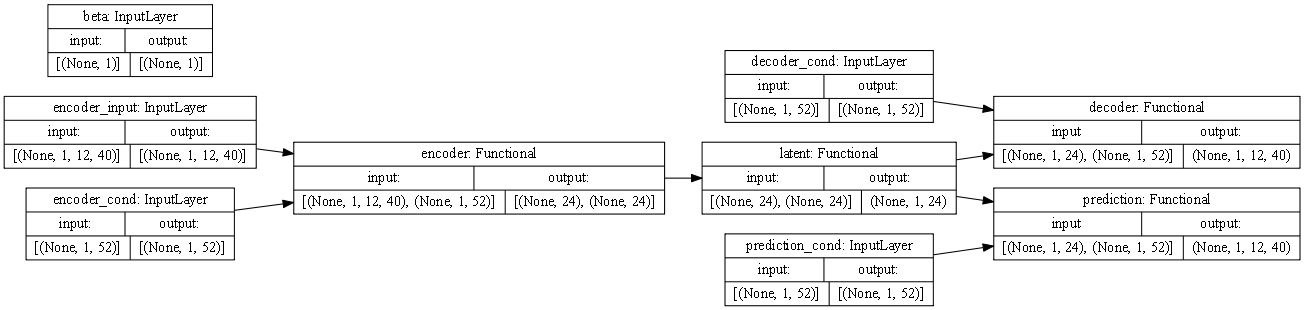

In [15]:
ks.utils.plot_model(model, show_shapes=True, dpi=75, rankdir='LR')

and summarizes the model

In [16]:
model.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 12, 40)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 52)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 24), (None, 24)]   187210        encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

### Load model weights (optional)

Optionally, we load model weights if `INITIAL_EPOCH > 0` to continue the pre-training.

In [17]:
if INITIAL_EPOCH > 0:
    epoch = min(INITIAL_EPOCH, params.model_fit['epochs'])
    model_file = os.path.join(log_dir, 'model.{epoch:02d}.h5'.format(epoch=epoch))
    model.load_weights(model_file, by_name=True)
    print('Load model weights from:', os.path.normpath(model_file))

Load model weights from: logs\2023-06-16T15.59\model.10.h5


## Data

In the following, we load the data for pre-training and transfer learning. The data is prepared with the CDO scripts. They are available on Github: https://andr-groth.github.io/cdo-scripts.

For the pre-training, we use CMIP6 data. The raw gridded data is prepared with the `prepare_data.sh` script. The script performs three main steps: creating anomalies, calculating ensemble EOFs, and obtaining individual PCs. The resulting data is stored in netCDF files and the folder is specified in `params.data['filename']`.

For the transfer learning, we use observational data. The raw gridded data is prepared with the `prepare_data2.sh` script. The script performs two main steps: creating anomalies and obtaining PCs. In contrast to the script `prepare_data.sh`, the EOFs are not calculated from the anomalies of the observational data. The anomalies are instead projected onto the ensemble EOFs calculated from the CMIP6 data to obtain the PCs. The resulting data is stored in netCDF files and the folder is specified in `params2.data['filename']`.

### CMIP data

First, we load the netCDF files of CMIP data for pre-training. 

In [18]:
_variables, _dimensions, _attributes = fileio.read_netcdf_multi(**params.data, num2date=True)

data\cmip6\historical\pr\pcs\pcs*.nc  : 103 file(s) found.
data\cmip6\historical\tos\pcs\pcs*.nc : 103 file(s) found.
206/206 [==============================] - 16s 79ms/file


We group the netCDF files and their variables by the global attributes  `source_id` + `variant_label`. The attribute `source_id` refers to the model name (e.g. `ACCESS-CM2`) and the attribute `variant_label` to the model run (e.g. `r1i1p1f1`).

In [19]:
variables = {}
key1 = 'source_id'
key2 = 'variant_label'
for data_name, values in _variables.items():
    target_key = (
        _attributes[data_name]['.'][key1],
        _attributes[data_name]['.'][key2],
    )

    variables.setdefault(target_key, {})
    variables[target_key] |= {k: pd.DataFrame(v, index=_dimensions[data_name]['time']) for k, v in values.items()}

We make a few tests to check the integrity of the data.

In [20]:
variable_names = {tuple(val.keys()) for val in variables.values()}
if len(variable_names) > 1:
    raise ValueError(f'More than one variable combination found: {variable_names}')
else:
    variable_names, *_ = variable_names
    print('\N{check mark} One variable combination found:', variable_names)

variable_channels = {tuple(v.shape[-1] for v in val.values()) for val in variables.values()}
if len(variable_channels) > 1:
    raise ValueError(f'More than one channel combination found: {variable_channels}')
else:
    variable_channels, *_ = variable_channels
    print('\N{check mark} One channel combination found:', variable_channels)

✓ One variable combination found: ('pr', 'tos')
✓ One channel combination found: (20, 20)


The following table summarizes the models and their different runs.

In [21]:
print('Number of model runs found :', len(variables))
df = pd.crosstab(*list(zip(*list(variables.keys()))), rownames=[key1], colnames=[key2])
df.loc['--- Total ---'] = df.sum(axis=0)
display(df.replace(0, ''))

Number of model runs found : 103


variant_label,r1i1p1f1,r2i1p1f1,r3i1p1f1
source_id,,,
ACCESS-CM2,1,1,1
ACCESS-ESM1-5,1,1,1
BCC-CSM2-MR,1,1,1
BCC-ESM1,1,1,1
CAMS-CSM1-0,1,1,
CAS-ESM2-0,1,1,1
CESM2,1,1,1
CESM2-FV2,1,1,1
CESM2-WACCM,1,1,1


The variables are stack along the last axis, the channels. We add a leading singleton dimension for `set_size=1`.

In [22]:
dataset_names = sorted(variables.keys(), key=lambda x: x[1])
data_stack = [
    pd.concat([variables[dataset_name][variable_name] for variable_name in variable_names], axis=1, join='inner')
    for dataset_name in dataset_names
]
time = [d.index for d in data_stack]
dataset = [d.to_numpy()[None, ...] for d in data_stack]

print('Shapes of model runs :', {val.shape for val in dataset})

Shapes of model runs : {(1, 1980, 40)}


We split the datasets into one set for training and one set for validation.

In [23]:
validation_split = params.fit_generator['validation_split']
print('Size of training dataset   :', validation_split)
print('Size of validation dataset :', len(dataset) - validation_split)

Size of training dataset   : 72
Size of validation dataset : 31


### Observational data

We load the netCDF data representing the observational data for transfer learning.

In [24]:
_variables2, _dimensions2, _attributes2 = fileio.read_netcdf_multi(**params.data2, num2date=True)

data\gpcc\prj\pcs_anom_gpcc_v2020_1dgr.nc : 1 file(s) found.
data\ersst\prj\pcs_anom_ersstv5.nc        : 1 file(s) found.
2/2 [==============================] - 0s 83ms/file


We assume a single set of different variables for observational data.

In [25]:
variables2 = {
    k: pd.DataFrame(v, index=_dimensions2[name]['time'])
    for name, values in _variables2.items() for k, v in values.items()
}

variable2_names = tuple(variables2.keys())
variable2_channels = tuple([v.shape[-1] for v in variables2.values()])
dataset2_names = 'Observations'

print('Variables found :', variable2_names)
print('Channel found   :', variable2_channels)

Variables found : ('precip', 'sst')
Channel found   : (20, 20)


We stack the different variables along the last axis, the channel axis, and add a leading singleton dimension for `set_size=1`.

In [26]:
data2_stack = pd.concat([variables2[variable2_name] for variable2_name in variable2_names], axis=1, join='inner')
time2 = data2_stack.index
dataset2 = data2_stack.to_numpy()[None, ...]

We split the observations into two time intervals, one for training and one for validation.

In [27]:
validation_split2 = np.searchsorted(time2, np.datetime64(params.fit_generator2['validation_split']))
print(f"Training interval   : {time2[:validation_split2][[0, -1]]}")
print(f"Validation interval : {time2[validation_split2:][[0, -1]]}")

Training interval   : DatetimeIndex(['1891-01-01', '1980-08-01'], dtype='datetime64[ns]', freq=None)
Validation interval : DatetimeIndex(['1980-09-01', '2019-12-01'], dtype='datetime64[ns]', freq=None)


### Plot data

In the following plot, we compare the CMIP datasets with the observations.

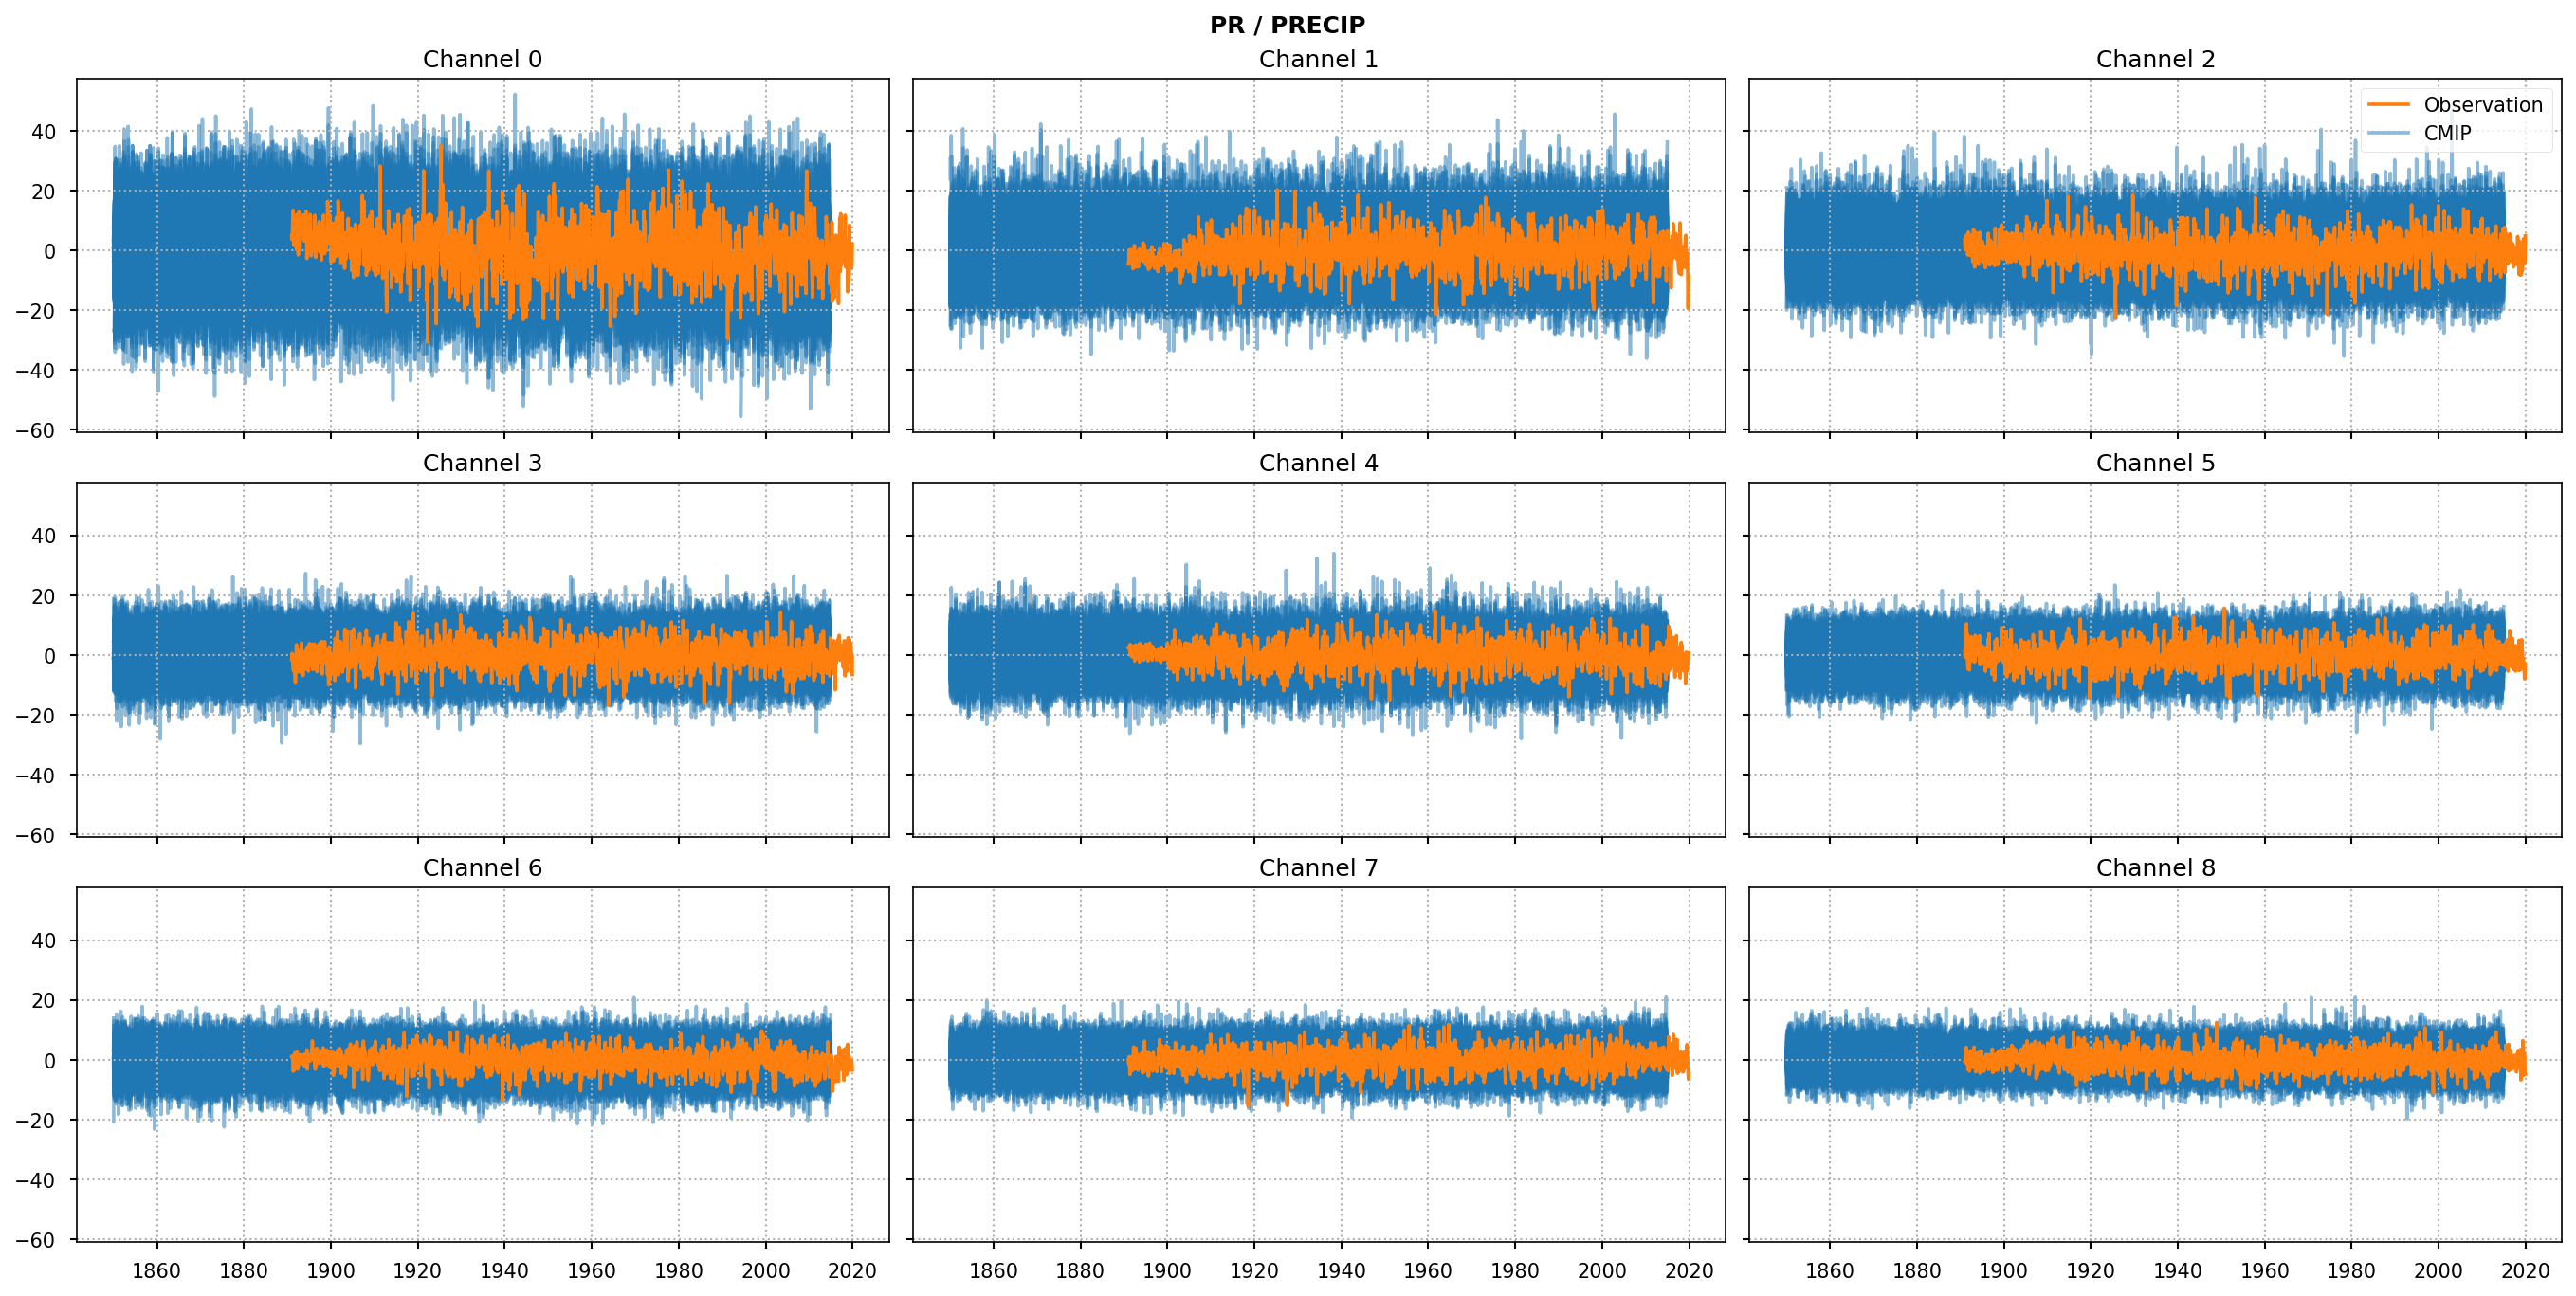

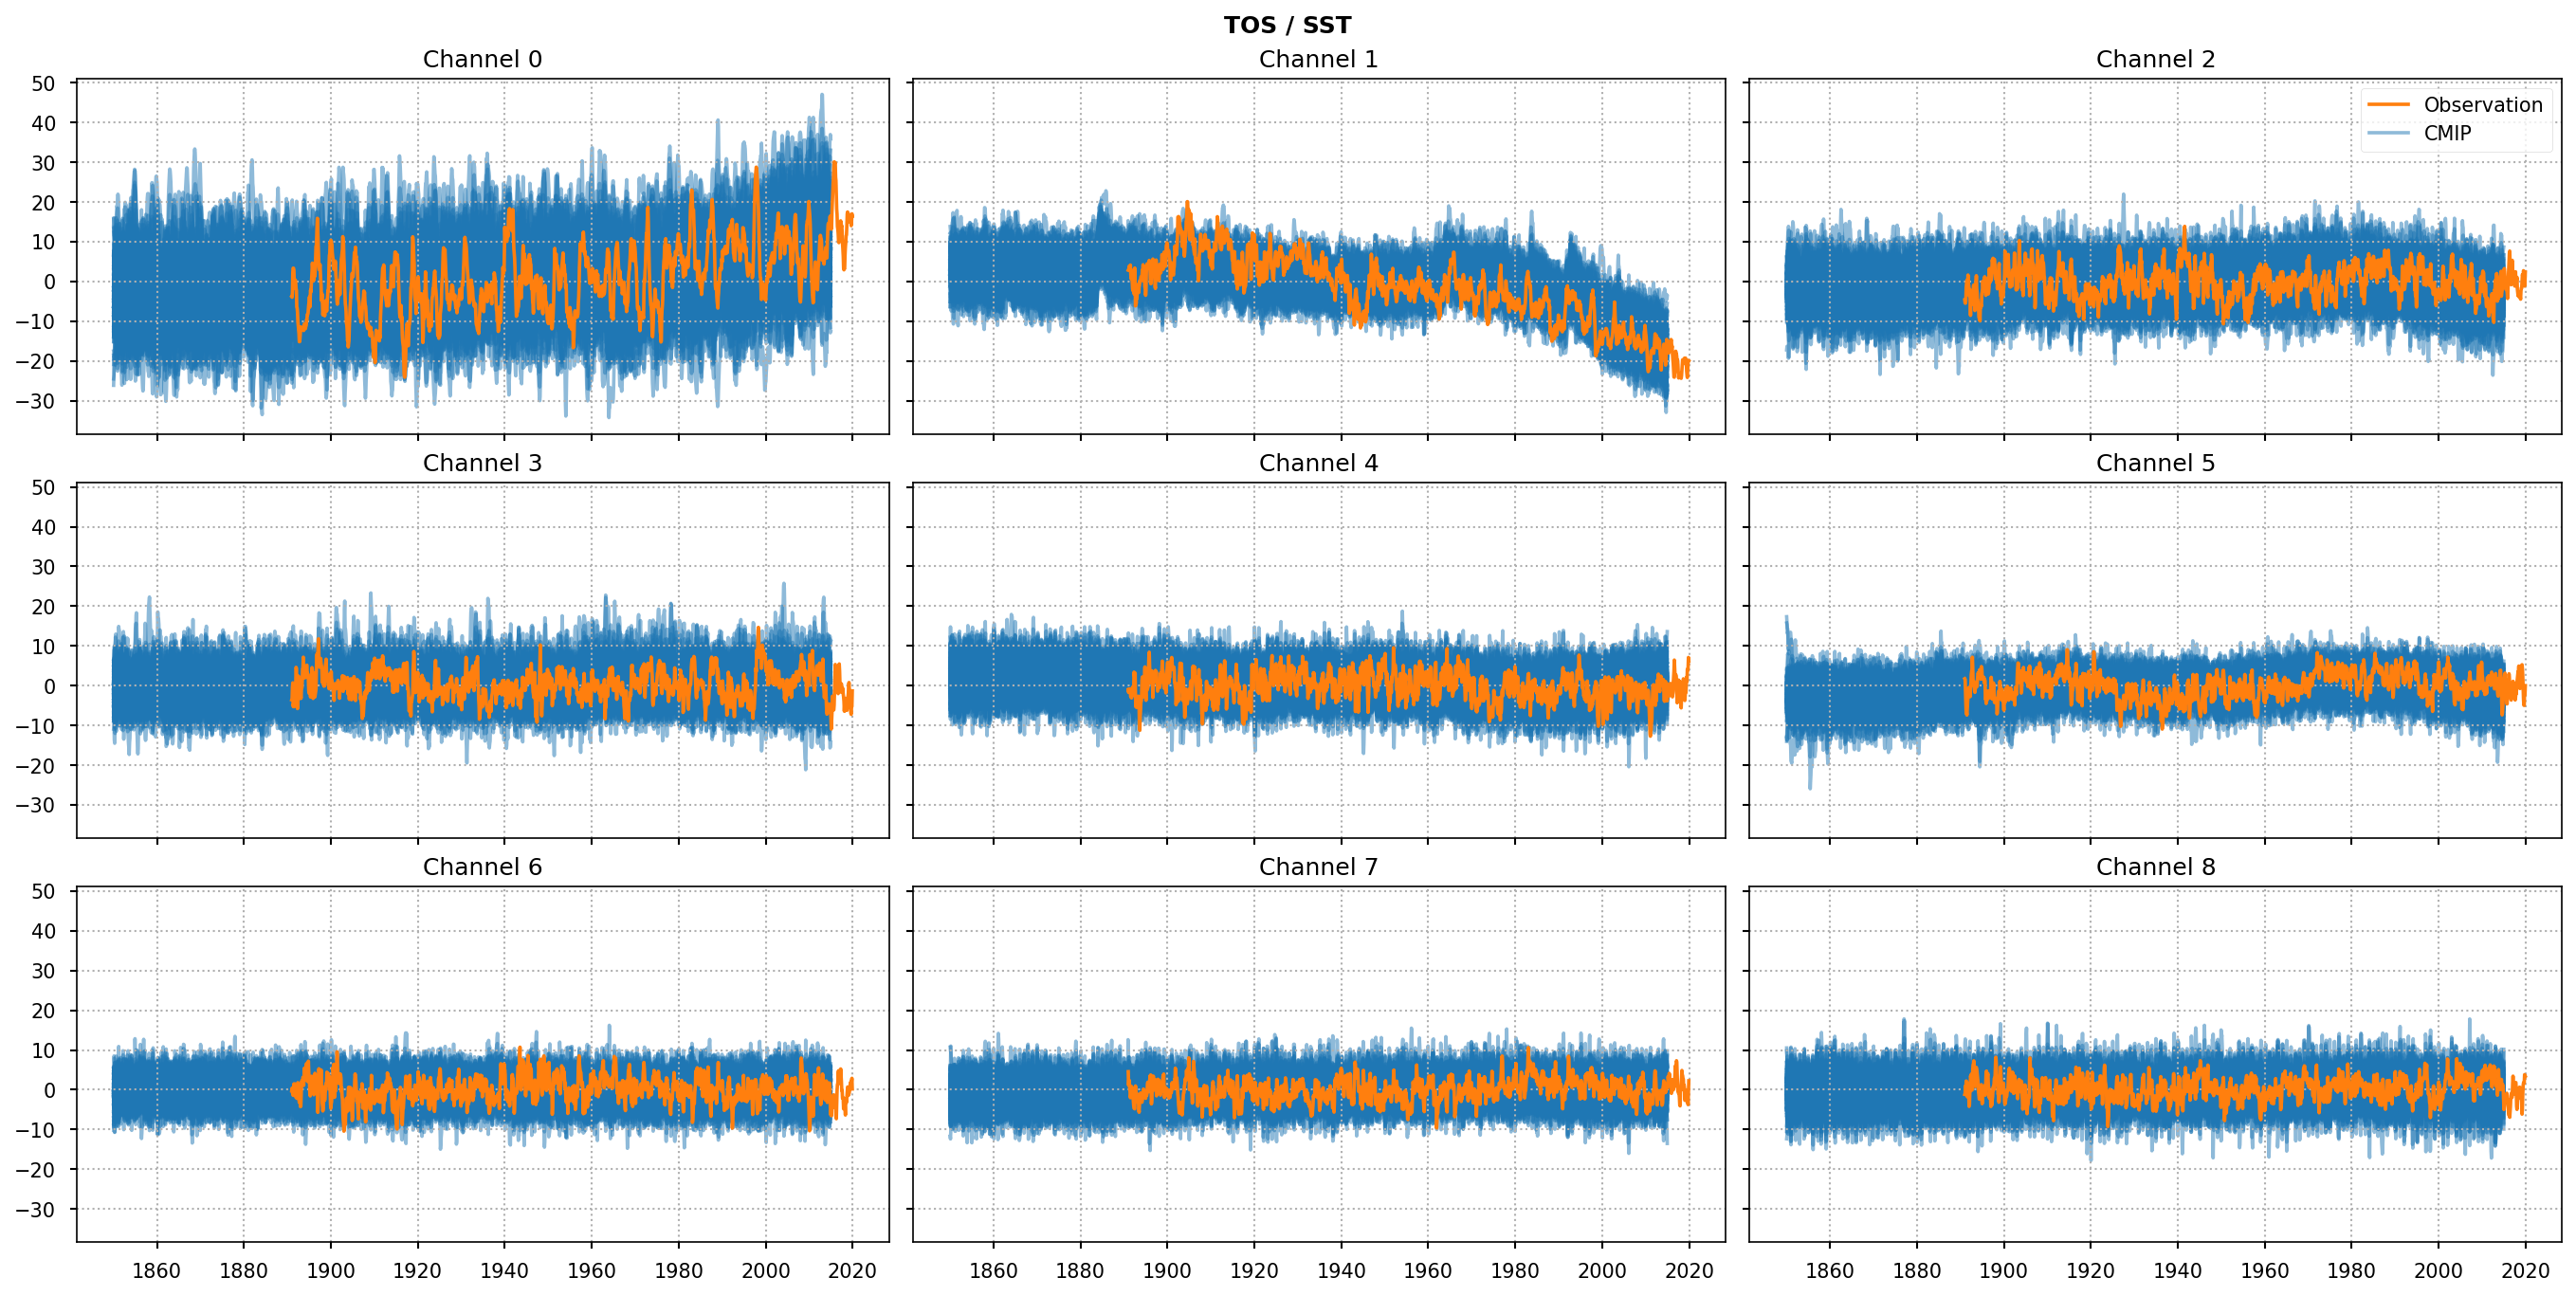

In [28]:
cols = 3
rows = 3

for variable_name, variable2_name in zip(variable_names, variable2_names):
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(6 * cols, 3 * rows), squeeze=False)
    fig.suptitle(variable_name.upper() + ' / ' + variable2_name.upper(), fontweight='bold')

    for channel, (ax, value) in enumerate(zip(axs.flat, variables2[variable2_name].values.T)):
        p2, = ax.plot(time2, value, color='tab:orange', zorder=2.2)
        ax.grid(linestyle=':')
        ax.set_title(f'Channel {channel}')

    for dataset_name in dataset_names:
        for channel, (ax, value) in enumerate(zip(axs.flat, variables[dataset_name][variable_name].values.T)):
            p1, = ax.plot(variables[dataset_name][variable_name].index, value, color='tab:blue', alpha=0.5, zorder=1.1)

    axs[0, -1].legend((p2, p1), ('Observation', 'CMIP'), loc='upper right')

We compare the variance of the two datasets.

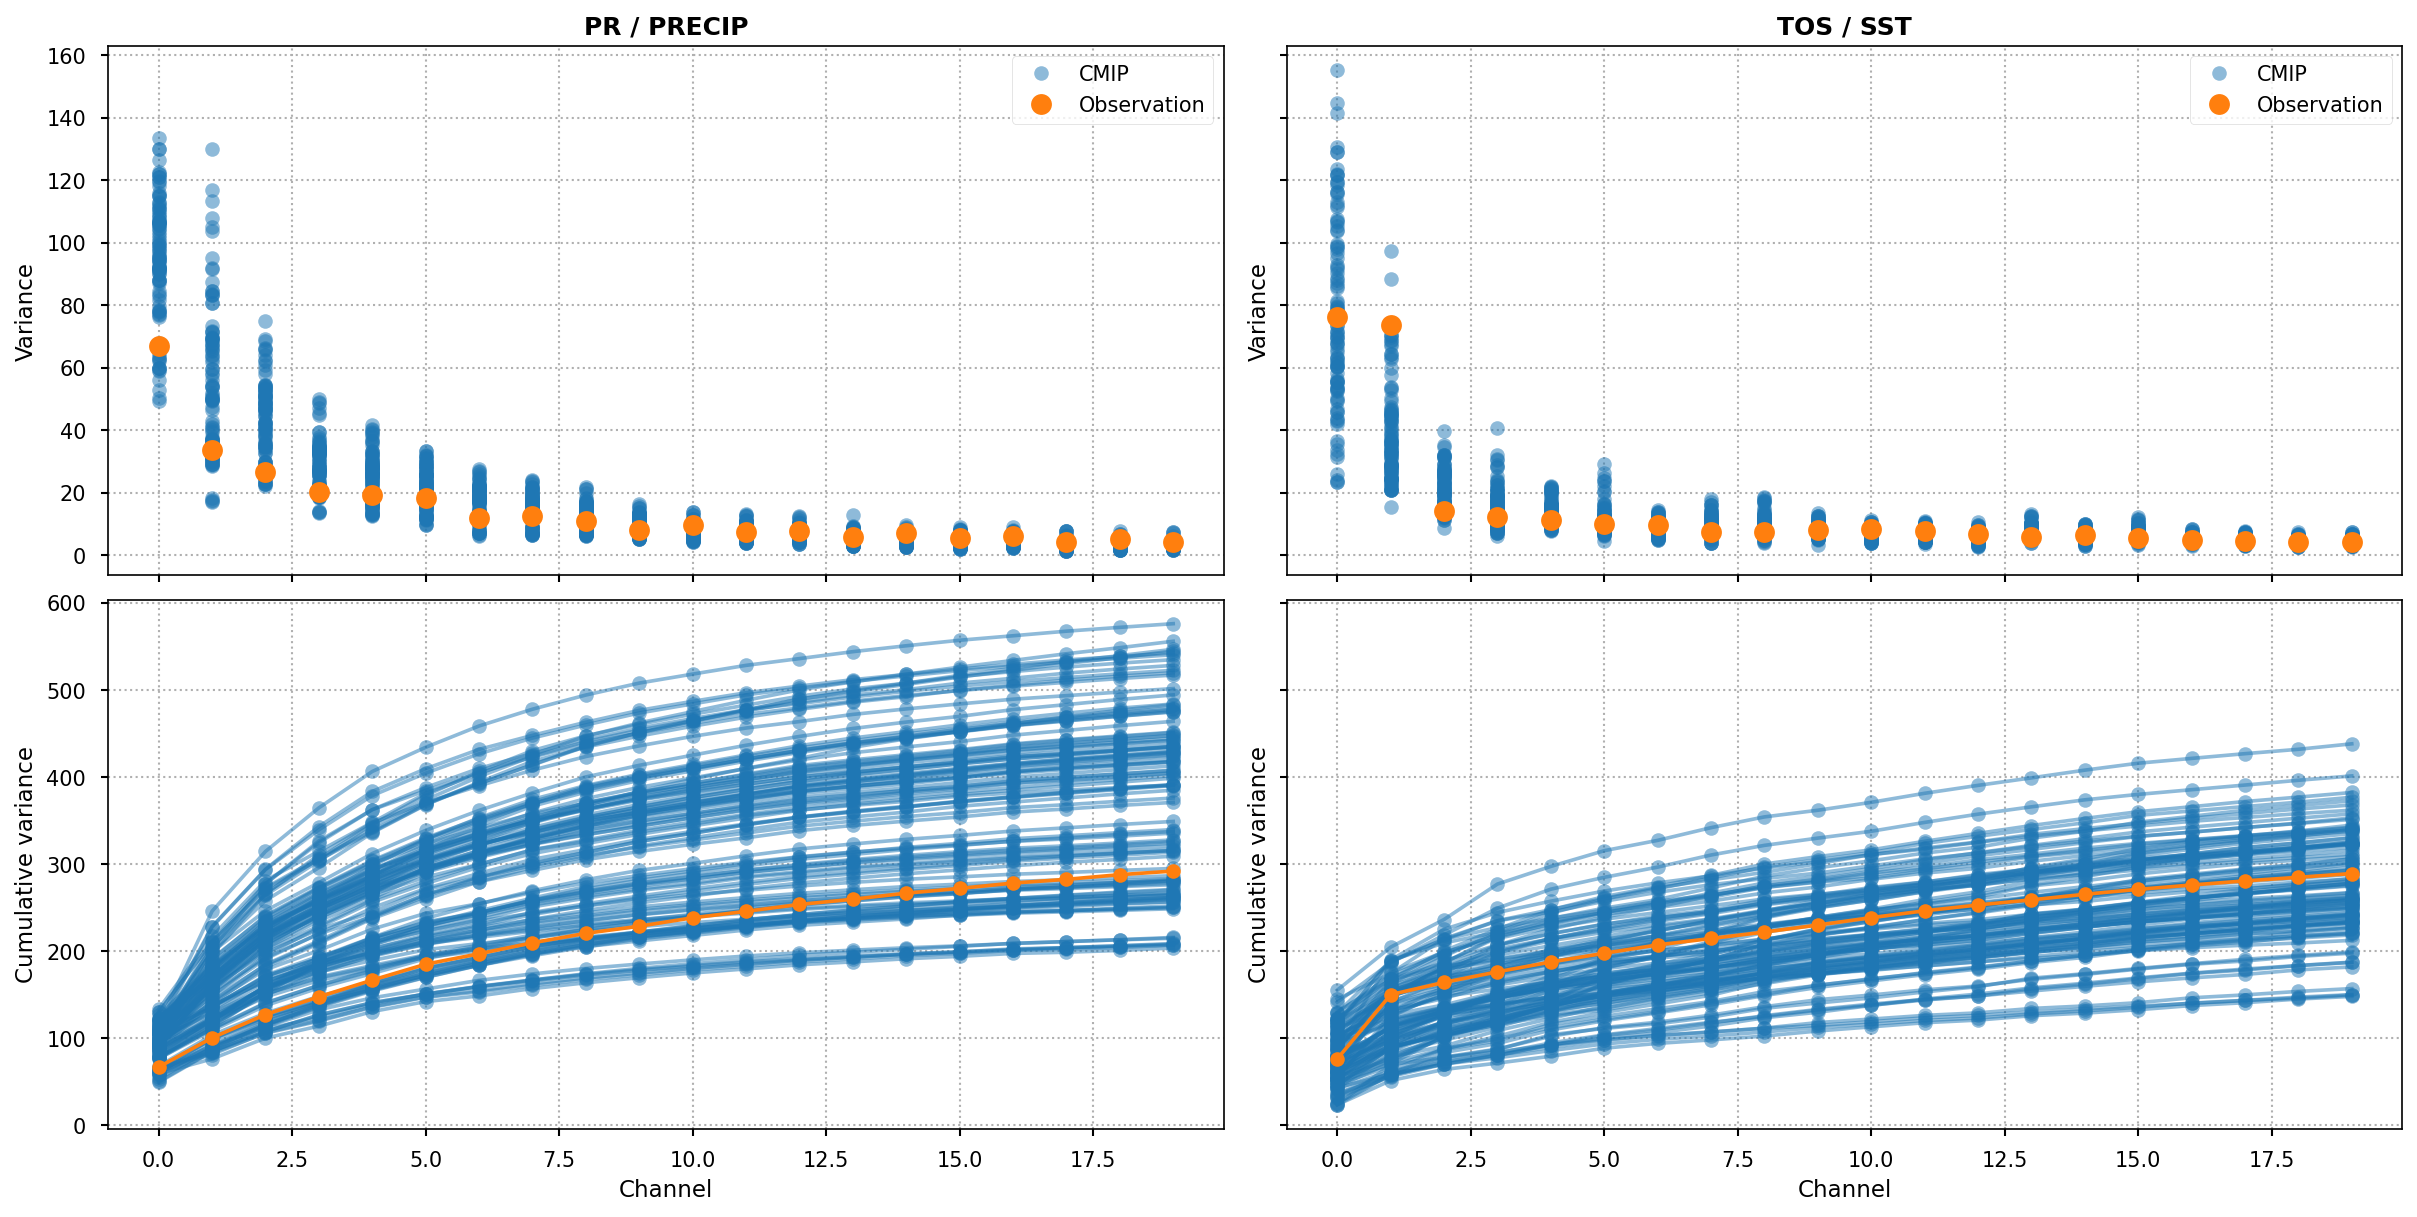

In [29]:
fig, axs = plt.subplots(2, len(variable_names), figsize=(16, 8), sharex=True, sharey='row', squeeze=False)
for (uax, bax), variable_name, variable2_name in zip(axs.T, variable_names, variable2_names):
    uax.set_title(variable_name.upper() + ' / ' + variable2_name.upper(), fontweight='bold')

    data_var = np.stack([values[variable_name].var(axis=0) for values in variables.values()], axis=1)
    p1, *_ = uax.plot(data_var, 'o', color='tab:blue', alpha=0.5, zorder=2.1)

    data2_var = variables2[variable2_name].var(axis=0)
    p2, = uax.plot(data2_var, 'o', color='tab:orange', markersize=10, zorder=2.2)

    data_cvar = np.cumsum(data_var, axis=0)
    bax.plot(data_cvar, '-o', color='tab:blue', alpha=0.5, zorder=2.1)

    data2_cvar = np.cumsum(data2_var, axis=0)
    bax.plot(data2_cvar, '-o', color='tab:orange', zorder=2.2)

    uax.legend((p1, p2), ('CMIP', 'Observation'))
    uax.set_ylabel('Variance')
    uax.grid(linestyle=':')

    bax.set_xlabel('Channel')
    bax.set_ylabel('Cumulative variance')
    bax.grid(linestyle=':')

## Pre-training

### Prepare generators

#### Beta scheduler

For the model training, we first need a scheduler for the beta values in each epoch that scales the KL loss. 

In [30]:
BetaScheduler = getattr(beta_schedulers, params.beta_scheduler.get('class_name'))
beta_scheduler = BetaScheduler(**params.beta_scheduler.get('config'))
beta_scheduler.summary()

Summary of "LogisticGrowth" (BetaScheduler)
  dtype    : float32
  lower    : 0.0
  upper    : 5
  midpoint : 5
  rate     : 1


#### Fit generator on CMIP

A first generator takes the first set of the CMIP data. This generator is used to pre-train the model.

In [31]:
month = [t.to_numpy().astype('datetime64[M]').astype(int) for t in time]
_, model_index = np.unique([dataset_name[0] for dataset_name in dataset_names], return_inverse=True)
fit_gen = generators.FitGenerator(dataset[:validation_split],
                                  **params.fit_generator,
                                  beta_scheduler=beta_scheduler,
                                  time=month[:validation_split],
                                  ensemble_index=model_index[:validation_split])
fit_gen.summary()

Number of datasets : 72
Total data size    : 5,702,400
Total data length  : 142,560
Strides            : 1
Number of samples  : 140,904
Batch size         : 128
Number of batches  : 1,101
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : True
Ensemble condition
  size : 40
  type : index
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (640, 1, 12, 40)
    encoder_cond     : (640, 1, 52)
    decoder_cond     : (640, 1, 52)
    prediction_cond  : (640, 1, 52)
    beta             : (640, 1)
  targets
    decoder          : (640, 1, 12, 40)
    prediction       : (640, 1, 12, 40)


#### Validation generator on CMIP

A second generator takes the second set of CMIP data. The generator is used to evaluate the sucess of the pre-training to generalize to independent CMIP runs.

In [32]:
if dataset[validation_split:]:
    val_gen = generators.FitGenerator(dataset[validation_split:],
                                      **params.fit_generator,
                                      beta_scheduler=beta_scheduler,
                                      time=month[validation_split:],
                                      ensemble_index=model_index[validation_split:])
    val_gen.summary()
else:
    val_gen = None
    print('No validation on CMIP data.')

Number of datasets : 31
Total data size    : 2,455,200
Total data length  : 61,380
Strides            : 1
Number of samples  : 60,667
Batch size         : 128
Number of batches  : 474
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : True
Ensemble condition
  size : 40
  type : index
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (640, 1, 12, 40)
    encoder_cond     : (640, 1, 52)
    decoder_cond     : (640, 1, 52)
    prediction_cond  : (640, 1, 52)
    beta             : (640, 1)
  targets
    decoder          : (640, 1, 12, 40)
    prediction       : (640, 1, 12, 40)


#### Validation generator on observations

A third generator takes the observational data. The generator is used to evaluate the success of the pre-training to model observational data. The validation scores are a proxy of a __zero-shot__ score on the observational data without transfer learning.

In [33]:
month2 = time2.to_numpy().astype('datetime64[M]').astype(int)
val_gen_obs = generators.FitGenerator(dataset2,
                                      beta_scheduler=beta_scheduler,
                                      time=month2,
                                      **{
                                          **params.fit_generator,
                                          **params.fit_generator2
                                      })
val_gen_obs.summary()

Number of datasets : 1
Total data size    : 61,920
Total data length  : 1,548
Strides            : 1
Number of samples  : 1,525
Batch size         : 32
Number of batches  : 48
Sample repetitions : 5
Actual batch size  : 32 * 5 = 160
Shuffle            : True
Ensemble condition
  size : 40
  type : random
  range   : (0, 40)
  sync    : True
  replace : False
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (160, 1, 12, 40)
    encoder_cond     : (160, 1, 52)
    decoder_cond     : (160, 1, 52)
    prediction_cond  : (160, 1, 52)
    beta             : (160, 1)
  targets
    decoder          : (160, 1, 12, 40)
    prediction       : (160, 1, 12, 40)


### Prepare callbacks

The callbacks are used to save the model weights and evaluation metrics in the `LOG_DIR`. The progress of the pre-training can be monitored and analyzed with Tensorboard.

In [34]:
callbacks = [
    ModelCheckpoint(filepath=os.path.join(log_dir, 'model.{epoch:02d}.h5'),
                    period=5,
                    save_best_only=False,
                    save_weights_only=True),
    Evaluate(val_gen_obs, prefix='val2_'),
    ks.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False),
]

### Fit model

Finally, we start the pre-training of the model.

In [35]:
hist = model.fit(fit_gen,
                 validation_data=val_gen,
                 initial_epoch=INITIAL_EPOCH,
                 **params.model_fit,
                 verbose=0,
                 callbacks=callbacks + [TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## Transfer learning

In the transfer learning, we only use the observational data.  Data prior to the validation split is used for the training and data after the validation split for validation.

### Prepare generators

#### Beta scheduler

A new beta schedular is created with an updated set of parameters.

In [36]:
bs_p = {**params.beta_scheduler, **params.beta_scheduler2}
BetaScheduler2 = getattr(beta_schedulers, bs_p['class_name'])
beta_scheduler2 = BetaScheduler2(**bs_p['config'])
beta_scheduler2.summary()

Summary of "LogisticGrowth" (BetaScheduler)
  dtype    : float32
  lower    : 0.0
  upper    : 5
  midpoint : 5
  rate     : 1


#### Fit generator

In the transfer learning, a first generator takes observational data prior to the validation split. This generator is used to continue the training of the modified model (see [Modify model](#Modify-model)).

In [37]:
month2 = time2.to_numpy().astype('datetime64[M]').astype(int)
fit_gen2 = generators.FitGenerator(dataset2[:, :validation_split2, :],
                                   beta_scheduler=beta_scheduler2,
                                   time=month2[:validation_split2],
                                   **{
                                       **params.fit_generator,
                                       **params.fit_generator2
                                   })
fit_gen2.summary()

Number of datasets : 1
Total data size    : 43,040
Total data length  : 1,076
Strides            : 1
Number of samples  : 1,053
Batch size         : 32
Number of batches  : 33
Sample repetitions : 5
Actual batch size  : 32 * 5 = 160
Shuffle            : True
Ensemble condition
  size : 40
  type : random
  range   : (0, 40)
  sync    : True
  replace : False
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (160, 1, 12, 40)
    encoder_cond     : (160, 1, 52)
    decoder_cond     : (160, 1, 52)
    prediction_cond  : (160, 1, 52)
    beta             : (160, 1)
  targets
    decoder          : (160, 1, 12, 40)
    prediction       : (160, 1, 12, 40)


#### Validation generator

A second generator takes observational data after the validation split and is used to evaluate the transfer learning.

In [38]:
val_gen2 = generators.FitGenerator(dataset2[:, validation_split2:, :],
                                   beta_scheduler=beta_scheduler2,
                                   time=month2[validation_split2:],
                                   **{
                                       **params.fit_generator,
                                       **params.fit_generator2
                                   })
val_gen2.summary()

Number of datasets : 1
Total data size    : 18,880
Total data length  : 472
Strides            : 1
Number of samples  : 449
Batch size         : 32
Number of batches  : 15
Sample repetitions : 5
Actual batch size  : 32 * 5 = 160
Shuffle            : True
Ensemble condition
  size : 40
  type : random
  range   : (0, 40)
  sync    : True
  replace : False
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (160, 1, 12, 40)
    encoder_cond     : (160, 1, 52)
    decoder_cond     : (160, 1, 52)
    prediction_cond  : (160, 1, 52)
    beta             : (160, 1)
  targets
    decoder          : (160, 1, 12, 40)
    prediction       : (160, 1, 12, 40)


### Modify model

In the transfer learning, we only fine-tune a subset of layers in the model, while keeping all other layers frozen. The list of trainable layers can be modified with the `trainable` item in `params.model2` that is used to build the modifed model.

In the following, we build a new full model `model2` with the same `encoder`, `decoder`, and `prediction` from the pre-trained `model`, but with some layers set to non-trainable.

In [39]:
model2 = models.VAEp(encoder, decoder, latent_sampling, prediction, **{**params.model, **params.model2})

In the summary below, we see that parameters are _trainable_ and _non-trainable_.

In [40]:
model2.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 12, 40)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 52)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 24), (None, 24)]   187210        encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

The following table summarizes the trainable layers and their number of parameters.

In [41]:
collection.summary_trainable(model2)

________________________________________________________________________________
Layer                                    Type                           # params
mVAEp                                    Functional                        3,966
________________________________________________________________________________
  encoder                                Functional                        1,322
    encoder_cond_id                      Dense                               246
    encoder_input_bn                     BatchNormalization                   80
    encoder_cond_dense_1                 Dense                               156
    encoder_cond_film                    Film                                 72
    encoder_block_1                      Functional                          256
      encoder_block_1_R1_bn1             BatchNormalization                  128
      encoder_block_1_R1_bn2             BatchNormalization                  128
    encoder_block_2         

### Load transfer-learned model weights (optional)

Load model weights if `INITIAL_EPOCH` is greater than the pre-training epochs to continue the transfer learning.

In [42]:
if (INITIAL_EPOCH > params.model_fit['epochs']):
    model_file = os.path.join(log_dir, 'model.{epoch:02d}.h5'.format(epoch=INITIAL_EPOCH))
    model.load_weights(model_file, by_name=True)
    print('Load model weights from:', os.path.normpath(model_file))

Load model weights from: logs\2023-06-16T15.59\model.100.h5


### Fit model

Finally, we start the transfer training

In [43]:
hist = model2.fit(fit_gen2,
                  validation_data=val_gen2,
                  initial_epoch=max(INITIAL_EPOCH, params.model_fit['epochs']),
                  epochs=params.model_fit2['epochs'],
                  callbacks=callbacks + [TqdmCallback(verbose=0)],
                  verbose=0)

0epoch [00:00, ?epoch/s]